In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [3]:
from itertools import islice

from comet_ml.api import API
from comet_ml.api import APIExperiment

import numpy as np

import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [4]:
with open('api_token.txt') as f:
    api_token = f.read()

api = API(api_token)

In [5]:
all_experiments = api.get('nokiroki1', 'coles-diploma')

In [6]:
def group_metrics(
    all_experiments: list[APIExperiment], metric_to_collect: str
) -> dict[str, list[np.ndarray]]:

    group_metrics = dict()

    for experiment in tqdm(all_experiments, leave=True):
        exp_name = experiment.name[:-2]
        steps = []
        values = []
        for param in experiment.get_metrics():
            if param['metricName'] == metric_to_collect:
                steps.append(param['step'])
                values.append(param['metricValue'])
        array = np.vstack(
            (np.array(steps), np.array(values)) 
        )
        if exp_name in group_metrics:
            group_metrics[exp_name].append(array)
        else:
            group_metrics[exp_name] = [array]
    return group_metrics

def get_agg_metrics(info):
    metrics_agg = {}

    for name in info:
        seq_len_min = min(info[name], key=lambda x: x.shape[1]).shape[1]

        steps = info[name][0][0, :seq_len_min]

        arrays = np.zeros((len(info[name]), seq_len_min))
        for i, arr in enumerate(info[name]):
            arrays[i] = arr[1, :seq_len_min]
        
        arrays_means = arrays.mean(0)
        arrays_std = arrays.std(0)

        arrays_upper = arrays_means + 1.96 * (arrays_std / np.sqrt(arrays.shape[0]))
        arrays_lower = arrays_means - 1.96 * (arrays_std / np.sqrt(arrays.shape[0]))

        metrics_agg[name] = [steps.astype(np.int32), arrays_means, arrays_upper, arrays_lower]
    return metrics_agg

def plot_metrics(info, title, x_name, y_name):
    plt.figure(figsize=(16, 10))

    for name, items in info.items():
        plt.plot(items[0], items[1], label=name)
        plt.fill_between(
            items[0],
            items[2],
            items[3],
            alpha=.2,
            color='green'
        )
    plt.title(title, fontsize=22)
    plt.xlabel(x_name, fontsize=16)
    plt.ylabel(y_name, fontsize=16)
    plt.xticks(size=18)
    plt.yticks(size=18)
    plt.locator_params(axis='x', nbins=10)
    plt.legend()
    plt.show();

In [7]:
losses = group_metrics(all_experiments, 'loss')
recalls = group_metrics(all_experiments, 'recall_top_k')

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [8]:
losses_agg = get_agg_metrics(losses)
recalls_agg = get_agg_metrics(recalls)

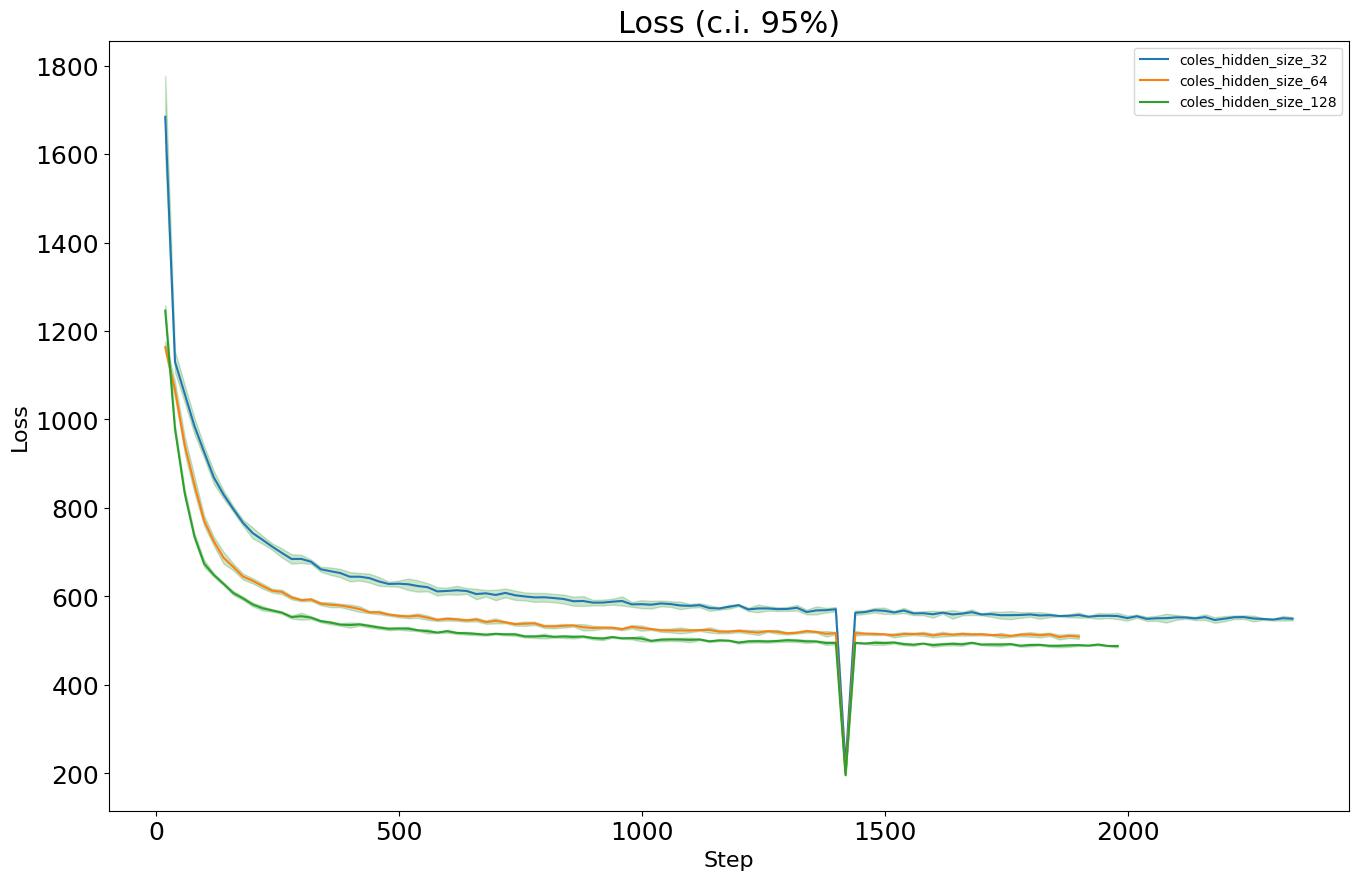

In [9]:
plot_metrics(losses_agg, 'Loss (c.i. 95%)', 'Step', 'Loss')

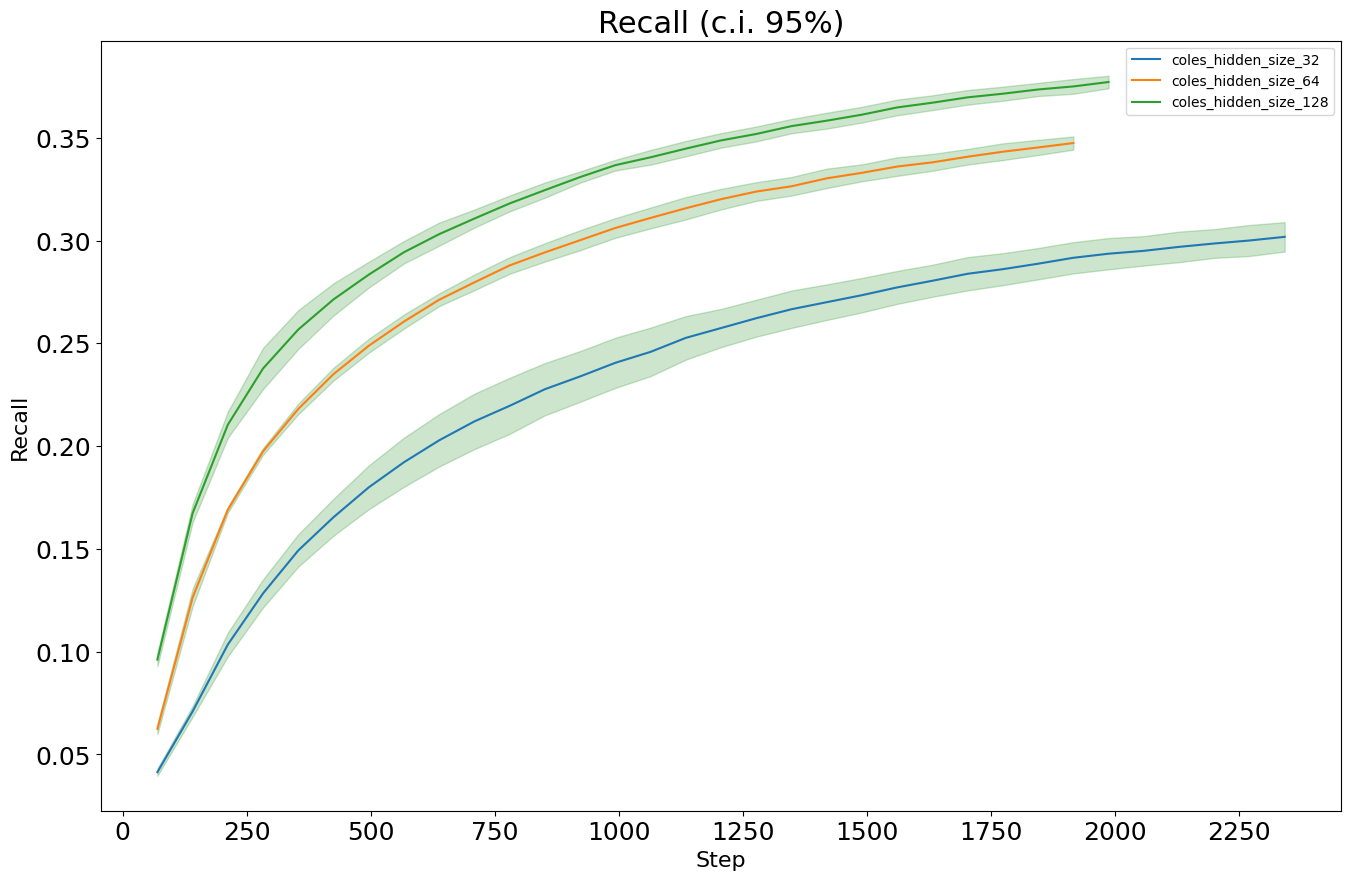

In [10]:
plot_metrics(recalls_agg, 'Recall (c.i. 95%)', 'Step', 'Recall')

In [11]:
all_experiments = api.get('nokiroki1', 'lstm-ae-diploma')

In [12]:
train_loss = group_metrics(all_experiments, 'train_loss')
val_loss = group_metrics(all_experiments, 'val_loss')

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [13]:
train_loss_amt = group_metrics(all_experiments, 'train_loss_amt')
train_loss_mcc = group_metrics(all_experiments, 'train_loss_mcc')
train_loss_binary = group_metrics(all_experiments, 'train_loss_binary')

val_loss_amt = group_metrics(all_experiments, 'val_loss_amt')
val_loss_mcc = group_metrics(all_experiments, 'val_loss_mcc')
val_loss_binary = group_metrics(all_experiments, 'val_loss_binary')

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [14]:
train_loss_amt_one = dict(islice(train_loss_amt.items(), 1))
train_loss_mcc_one = dict(islice(train_loss_mcc.items(), 1))
train_loss_binary_one = dict(islice(train_loss_binary.items(), 1))
val_loss_amt_one = dict(islice(val_loss_amt.items(), 1))
val_loss_mcc_one = dict(islice(val_loss_mcc.items(), 1))
val_loss_binary_one = dict(islice(val_loss_binary.items(), 1))

In [15]:
train_loss_amt_agg = get_agg_metrics(train_loss_amt_one)
train_loss_mcc_agg = get_agg_metrics(train_loss_mcc_one)
train_loss_binary_agg = get_agg_metrics(train_loss_binary_one)
val_loss_amt_agg = get_agg_metrics(val_loss_amt_one)
val_loss_mcc_agg = get_agg_metrics(val_loss_mcc_one)
val_loss_binary_agg = get_agg_metrics(val_loss_binary_one)

In [16]:
train_loss.keys()

dict_keys(['lstm__embed_dim64_num_layers_1', 'lstm__embed_dim64_num_layers_2', 'lstm__embed_dim128_num_layers_1', 'lstm__embed_dim128_num_layers_2', 'lstm__embed_dim128_num_layers_1_user_embed_32_masked_pred_None', 'lstm__embed_dim128_num_layers_1_user_embed_32_masked_pred_0.2', 'lstm__embed_dim128_num_layers_1_user_embed_32_masked_pred_0.3', 'lstm__embed_dim128_num_layers_1_user_embed_32_masked_pred_0.4'])

In [17]:
train_loss_first = dict(islice(train_loss.items(), 4))
val_loss_first = dict(islice(val_loss.items(), 4))

In [18]:
train_loss_agg = get_agg_metrics(train_loss_first)
val_loss_agg = get_agg_metrics(val_loss_first)

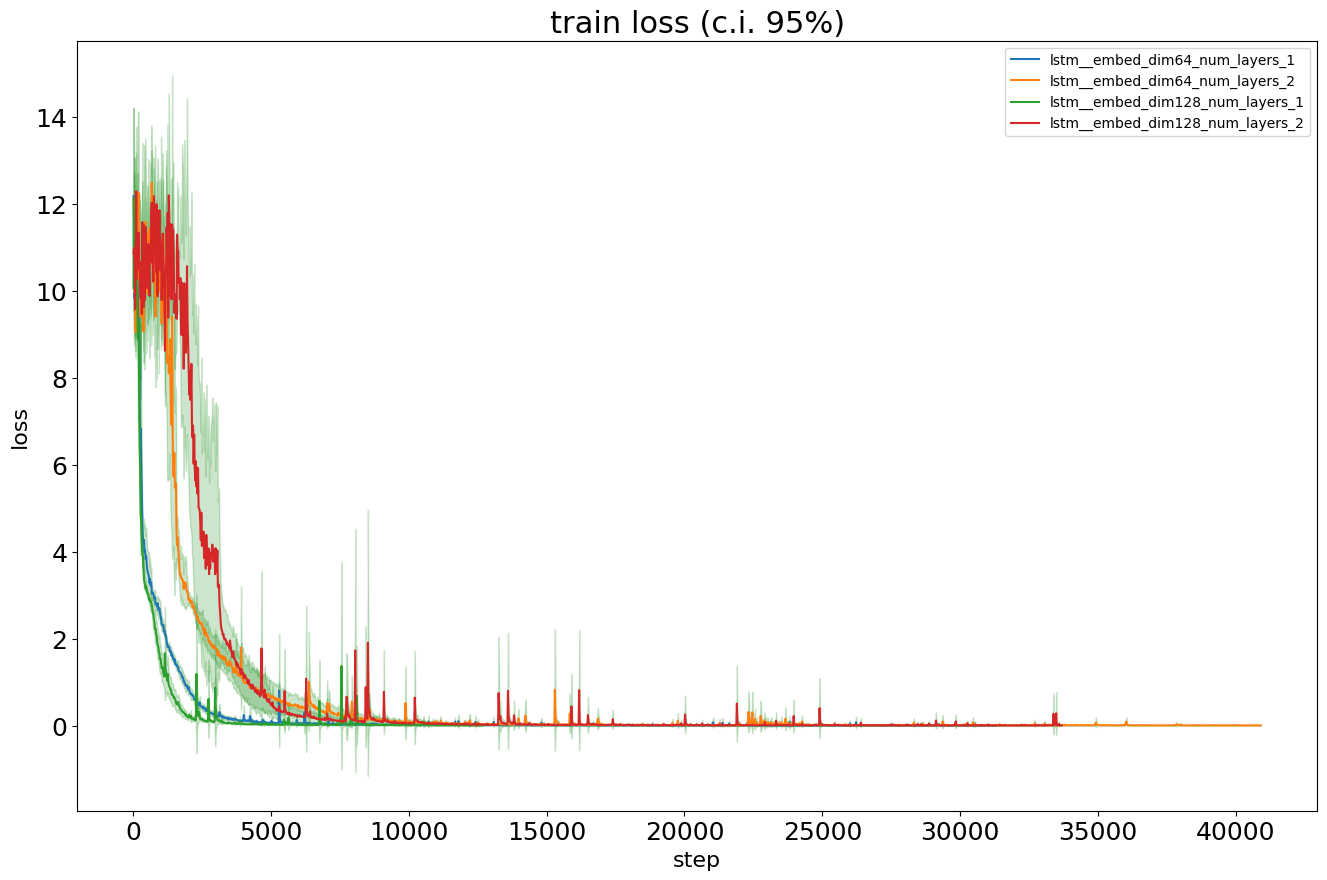

In [19]:
plot_metrics(train_loss_agg, 'train loss (c.i. 95%)', 'step', 'loss')

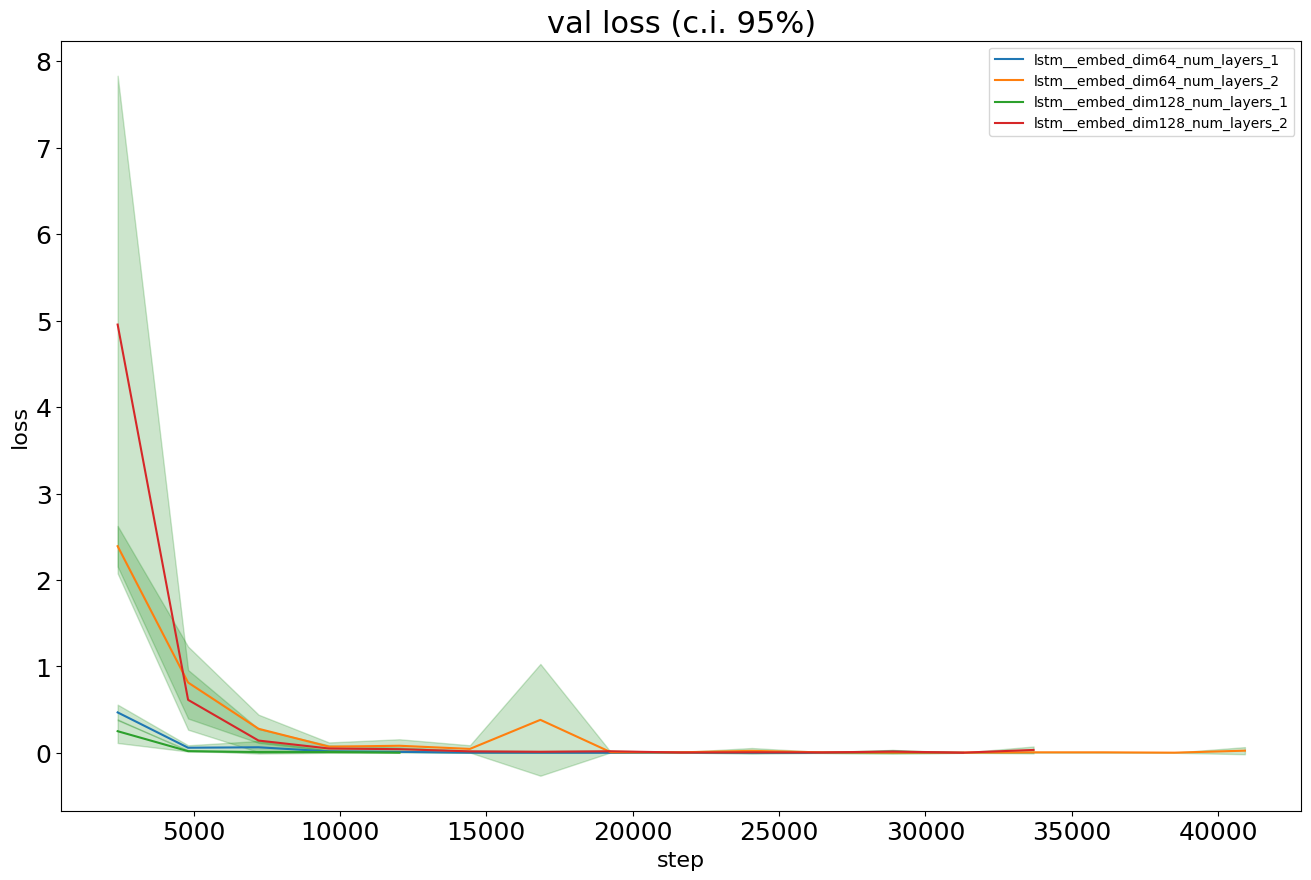

In [20]:
plot_metrics(val_loss_agg, 'val loss (c.i. 95%)', 'step', 'loss')

In [21]:
train_loss_second = dict(islice(train_loss.items(), 4, 100))
val_loss_second = dict(islice(val_loss.items(), 4, 100))

In [22]:
train_loss_agg = get_agg_metrics(train_loss_second)
val_loss_agg = get_agg_metrics(val_loss_second)

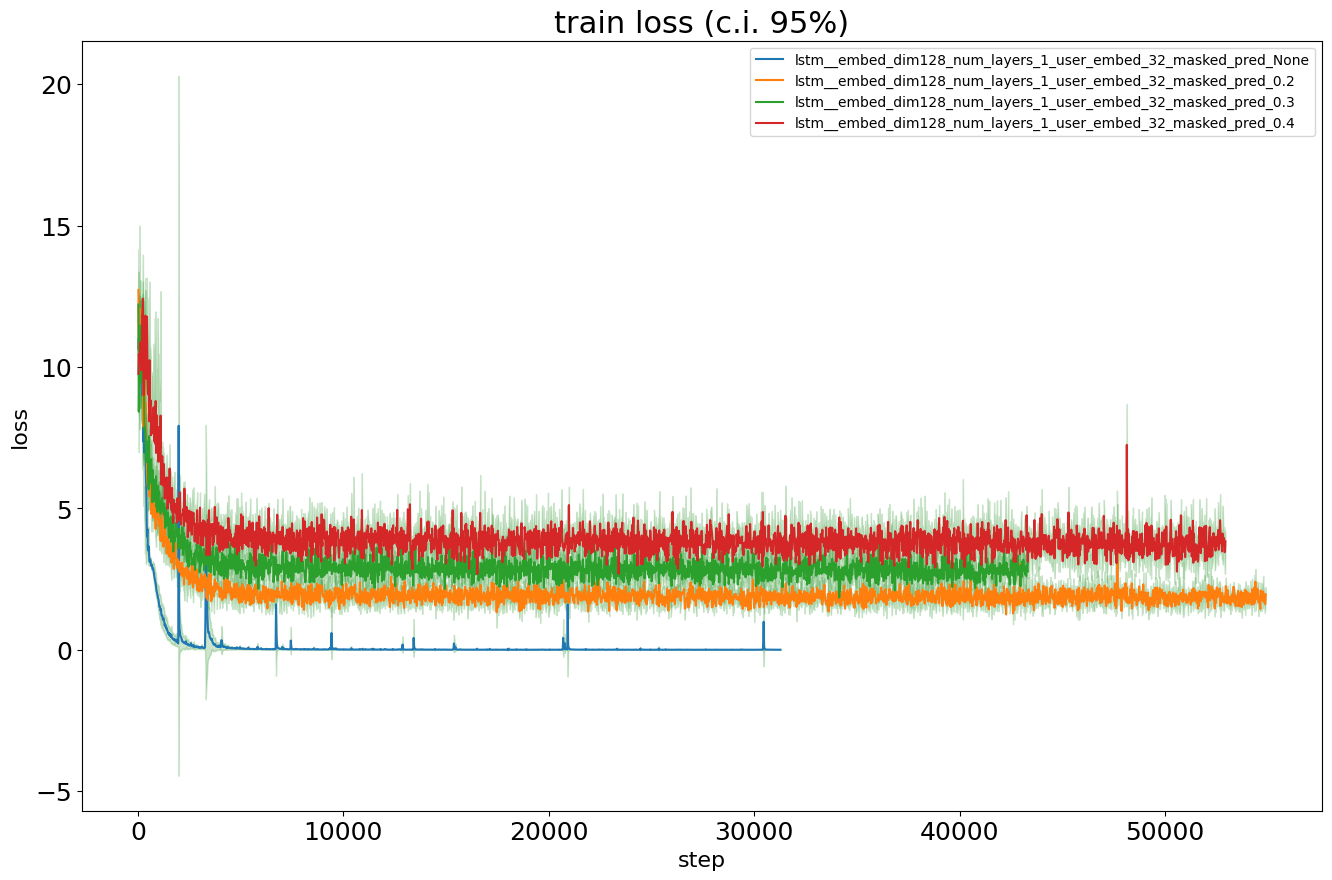

In [23]:
plot_metrics(train_loss_agg, 'train loss (c.i. 95%)', 'step', 'loss')

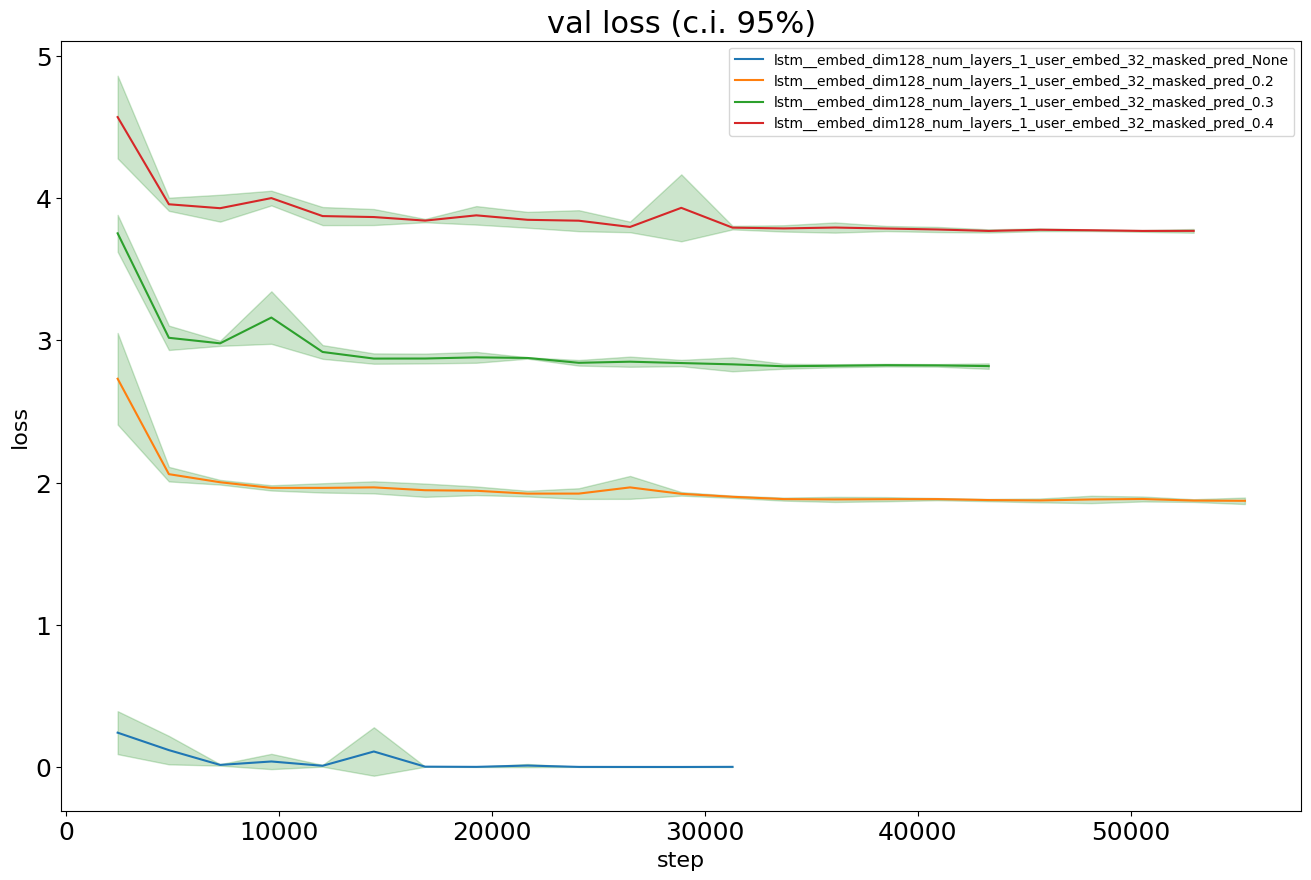

In [24]:
plot_metrics(val_loss_agg, 'val loss (c.i. 95%)', 'step', 'loss')

In [25]:
train_mcc_f1 = group_metrics(all_experiments, 'train_mcc_f1')
val_mcc_f1 = group_metrics(all_experiments, 'val_mcc_f1')

train_amt_r2 = group_metrics(all_experiments, 'train_amt_r2')
val_amt_r2 = group_metrics(all_experiments, 'val_amt_r2')

train_binary_f1 = group_metrics(all_experiments, 'train_binary_f1')
val_binary_f1 = group_metrics(all_experiments, 'val_binary_f1')

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

In [26]:
train_mcc_first = dict(islice(train_mcc_f1.items(), 4))
val_mcc_first = dict(islice(val_mcc_f1.items(), 4))

train_amt_first = dict(islice(train_amt_r2.items(), 4))
val_amt_first = dict(islice(val_amt_r2.items(), 4))

train_binary_first = dict(islice(train_binary_f1.items(), 4))
val_binary_first = dict(islice(val_binary_f1.items(), 4))

train_mcc_agg_first = get_agg_metrics(train_mcc_first)
val_mcc_agg_first = get_agg_metrics(val_mcc_first)

train_amt_agg_first = get_agg_metrics(train_amt_first)
val_amt_agg_first = get_agg_metrics(val_amt_first)

train_binary_agg_first = get_agg_metrics(train_binary_first)
val_binary_agg_first = get_agg_metrics(val_binary_first)

In [27]:
train_mcc_second = dict(islice(train_mcc_f1.items(), 4, 100))
val_mcc_second = dict(islice(val_mcc_f1.items(), 4, 100))

train_amt_second = dict(islice(train_amt_r2.items(), 4, 100))
val_amt_second = dict(islice(val_amt_r2.items(), 4, 100))

train_binary_second = dict(islice(train_binary_f1.items(), 4, 100))
val_binary_second = dict(islice(val_binary_f1.items(), 4, 100))

train_mcc_agg_second = get_agg_metrics(train_mcc_second)
val_mcc_agg_second = get_agg_metrics(val_mcc_second)

train_amt_agg_second = get_agg_metrics(train_amt_second)
val_amt_agg_second = get_agg_metrics(val_amt_second)

train_binary_agg_second = get_agg_metrics(train_binary_second)
val_binary_agg_second = get_agg_metrics(val_binary_second)

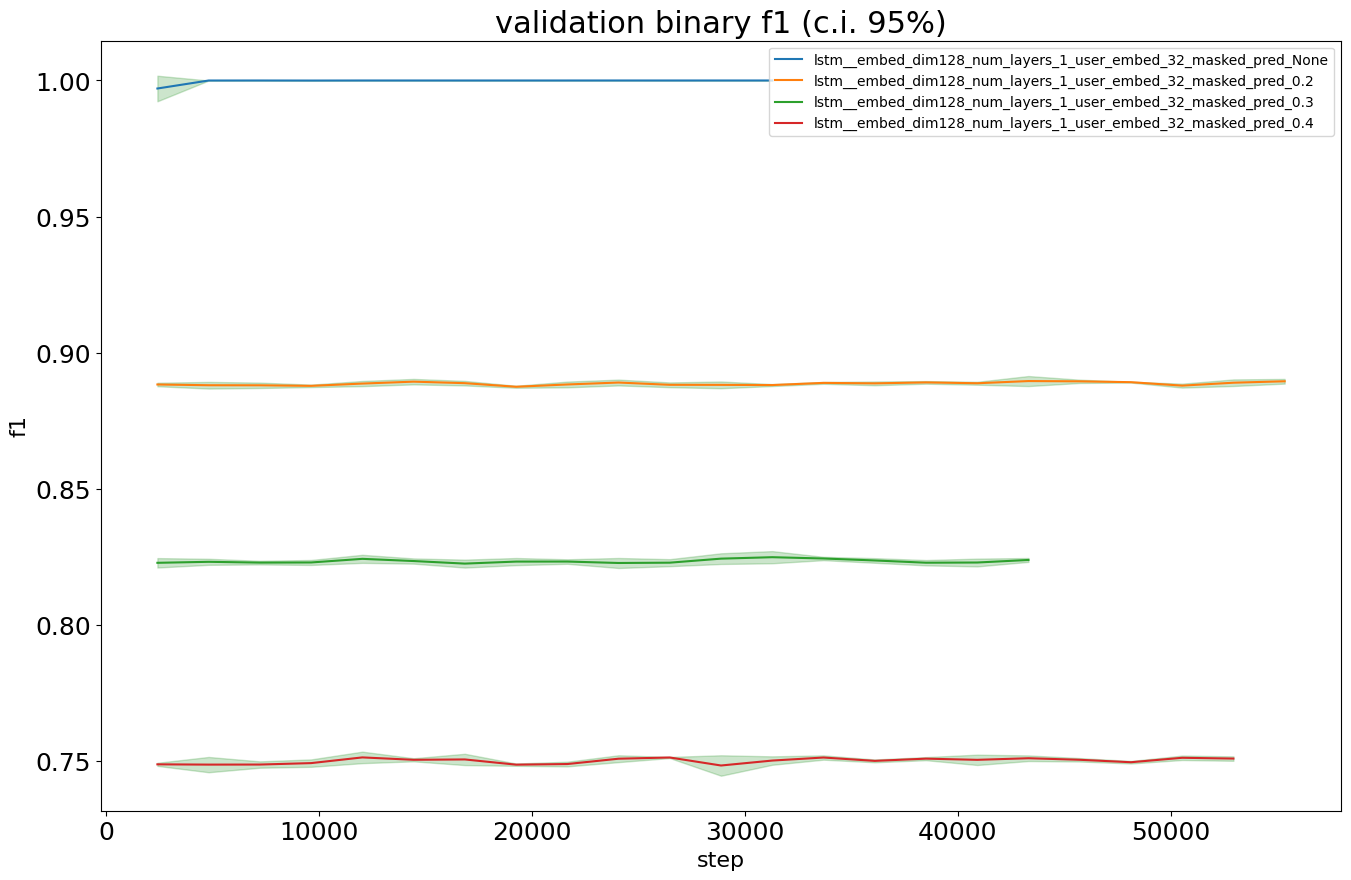

In [40]:
plot_metrics(val_binary_agg_second, 'validation binary f1 (c.i. 95%)', 'step', 'f1')